In [11]:
import glob
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    AutoTokenizer
)






In [12]:
# Import necessary libraries
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# File path pattern for CSV files
file_path_pattern = r'C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\Code\DASP_report_template\Dasp_new\DASP_report_template\data\disapere\*.csv'

# Fetch all CSV files matching the pattern
csv_files = glob.glob(file_path_pattern)

# Check if there are any CSV files in the specified directory
if len(csv_files) == 0:
    raise FileNotFoundError("Keine CSV-Dateien im angegebenen Verzeichnis gefunden.")

# Load all CSV files and combine them into a single DataFrame
combined_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Keep only the 'text' and 'aspect' columns, and rename them to 'data' and 'labels'
df = combined_df[['text', 'aspect']].rename(columns={'aspect': 'labels', 'text': 'data'})

# Remove duplicate rows based on 'data' and 'labels' columns
df.drop_duplicates(subset=['data', 'labels'], keep='first', inplace=True)

# Filter out rows where 'data' contains fewer than 3 words
df = df[df['data'].apply(lambda x: len(str(x).split()) >= 3)]

# List of all possible labels, including "none"
all_labels_list = [
    "none",
    "asp_substance",
    "asp_originality",
    "asp_clarity",
    "asp_soundness-correctness",
    "asp_motivation-impact",
    "asp_meaningful-comparison",
    "asp_replicability",
    "arg_other"
]

# Create dictionaries to map labels to integers and vice versa
int_to_label = {i: label for i, label in enumerate(all_labels_list)}
label_to_int = {label: i for i, label in int_to_label.items()}

# Convert labels in the DataFrame to their corresponding integer representations
df["encoded_cat"] = df["labels"].apply(lambda x: label_to_int[x])

# Split data into training (70%) and remaining (30%) datasets, stratified by encoded labels
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["encoded_cat"])

# Split the remaining 30% into validation (20%) and test (10%) datasets, maintaining stratification
val_df, test_df = train_test_split(temp_df, test_size=0.3333, random_state=42, stratify=temp_df["encoded_cat"])

# Print the number of samples in each split
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 6390, Val: 1826, Test: 913


C:\Users\carme\AppData\Local\Temp\ipykernel_20608\1943229676.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


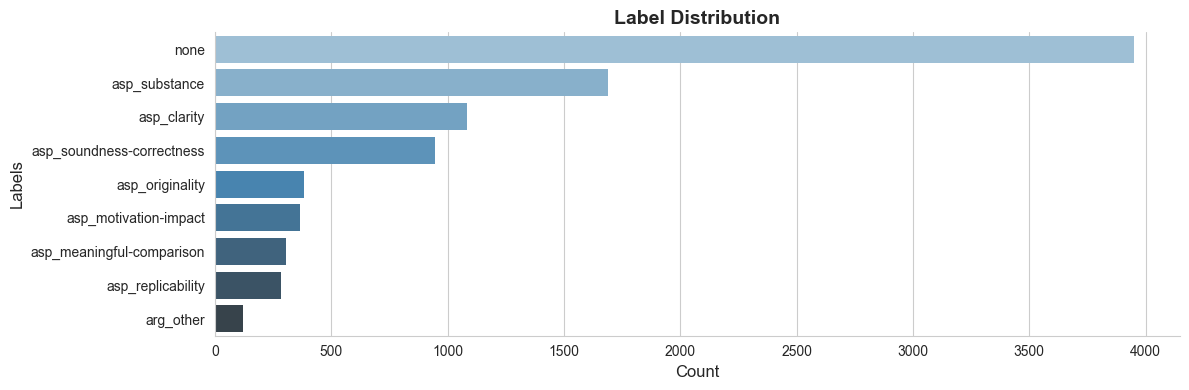

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Set a clean aesthetic style
sns.set_style("whitegrid")

# 2) Count the labels and sort descending
label_counts = df["labels"].value_counts().sort_values(ascending=False)

# 3) Create a wide, shallow figure
plt.figure(figsize=(12, 4))

# 4) Plot a horizontal bar chart
#    (x-axis = counts, y-axis = labels)
sns.barplot(
    x=label_counts.values,
    y=label_counts.index,
    palette="Blues_d",
    edgecolor='none',   # No black border
    linewidth=0
)

# 5) Label axes and add a title
plt.xlabel("Count", fontsize=12)
plt.ylabel("Labels", fontsize=12)
plt.title("Label Distribution", fontsize=14, fontweight="bold")

# 6) Remove unnecessary spines and tighten layout
sns.despine()
plt.tight_layout()

# 7) Optional: Save as a high-resolution import matplotlib.pyplot as plt
import seaborn as sns

# 1) Set a clean aesthetic style for the plot
sns.set_style("whitegrid")

# 2) Count the labels in the 'labels' column and sort them in descending order
label_counts = df["labels"].value_counts().sort_values(ascending=False)

# 3) Create a wide and shallow figure for better visualization
plt.figure(figsize=(12, 4))

# 4) Plot a horizontal bar chart with:
#    - x-axis representing the counts of labels
#    - y-axis representing the label names
sns.barplot(
    x=label_counts.values,  # Counts of labels
    y=label_counts.index,   # Label names
    palette="Blues_d",      # Use a blue gradient palette
    edgecolor='none',       # Remove black borders around bars
    linewidth=0             # Ensure no borders around bars
)

# 5) Add axis labels and a title with appropriate font sizes and styling
plt.xlabel("Count", fontsize=12)              # Label for the x-axis
plt.ylabel("Labels", fontsize=12)             # Label for the y-axis
plt.title("Label Distribution", fontsize=14, fontweight="bold")  # Title of the plot

# 6) Remove unnecessary spines (top and right borders) and optimize layout
sns.despine()          # Removes unnecessary spines
plt.tight_layout()     # Adjust layout to fit elements neatly

# 7) Optional: Save the figure as a high-resolution PNG image (e.g., for embedding in documents)
plt.savefig("label_distribution_horizontal.png", dpi=300)

# 8) Display the plot
plt.show()
PNG for Word
plt.savefig("label_distribution_horizontal.png", dpi=300)

# 8) Display the figure
plt.show()


In [4]:
# =========================================
# 2) Hilfsfunktionen
# =========================================

def oversample_dataframe(input_df, skip_label="None"):
    """
    Simple oversampling function that doubles the count of each class (except the skip_label).
    Parameters:
        input_df (DataFrame): The input DataFrame containing data and labels.
        skip_label (str): A label to exclude from oversampling. Default is "None".
    Returns:
        DataFrame: The oversampled DataFrame with balanced class distribution.
    """
    aspects = [lbl for lbl in all_labels_list if lbl != skip_label]  # Exclude the skip_label
    output_df = input_df.copy()

    # Oversample each class by duplicating its samples
    for aspect in aspects:
        subset = output_df[output_df["labels"] == aspect]
        count = len(subset)
        if count > 0:
            resampled = subset.sample(n=count, replace=True, random_state=42)  # Resample with replacement
            output_df = pd.concat([output_df, resampled], ignore_index=True)
    return output_df


def encode_data(tokenizer, df):
    """
    Tokenizes text data and returns encodings along with labels as PyTorch tensors.
    Parameters:
        tokenizer (Tokenizer): The tokenizer to process text data.
        df (DataFrame): The DataFrame containing 'data' and 'encoded_cat' columns.
    Returns:
        Tuple: Encoded text data and labels as tensors.
    """
    texts = df["data"].tolist()
    labels = df["encoded_cat"].tolist()

    encodings = tokenizer(texts, truncation=True, padding=True)  # Tokenize text data
    labels_tensor = torch.tensor(labels, dtype=torch.long)      # Convert labels to tensor

    return encodings, labels_tensor


class CustomDataset(Dataset):
    """
    A simple dataset class for handling encodings and labels during training.
    Parameters:
        encodings (dict): Encoded text data from the tokenizer.
        labels (Tensor): Labels corresponding to the encoded data.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing encodings and labels for a given index.
        Parameters:
            idx (int): The index of the desired sample.
        Returns:
            dict: A dictionary with encodings and corresponding labels.
        """
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)


def compute_metrics(pred):
    """
    Computes simple accuracy as an evaluation metric.
    Parameters:
        pred (PredictionOutput): The output containing predictions and labels.
    Returns:
        dict: A dictionary with the accuracy score.
    """
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)  # Get predicted class
    accuracy = (preds == labels).mean()         # Calculate accuracy
    return {"accuracy": accuracy}


def create_trainer(model, tokenizer, train_df, val_df, num_epochs=10, output_dir="./results"):
    """
    Creates a Hugging Face Trainer instance for training and evaluation.
    Parameters:
        model (PreTrainedModel): The model to be trained.
        tokenizer (Tokenizer): The tokenizer for text processing.
        train_df (DataFrame): The training data.
        val_df (DataFrame): The validation data.
        num_epochs (int): Number of training epochs. Default is 10.
        output_dir (str): Directory to save model outputs. Default is "./results".
    Returns:
        Trainer: A Hugging Face Trainer instance.
    """
    # Tokenize and encode training and validation data
    train_encodings, train_labels = encode_data(tokenizer, train_df)
    val_encodings, val_labels = encode_data(tokenizer, val_df)

    # Create custom datasets for training and validation
    train_dataset = CustomDataset(train_encodings, train_labels)
    val_dataset = CustomDataset(val_encodings, val_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",       # Evaluate after each epoch
        save_strategy="epoch",             # Save model after each epoch
        learning_rate=5e-5,                # Set learning rate
        per_device_train_batch_size=16,    # Training batch size
        per_device_eval_batch_size=64,     # Evaluation batch size
        num_train_epochs=num_epochs,       # Number of training epochs
        weight_decay=0.01,                 # Weight decay for regularization
        logging_dir='./logs',              # Directory for logging
        load_best_model_at_end=True,       # Load best model based on metric
        metric_for_best_model="accuracy",  # Metric to determine best model
        greater_is_better=True,            # Higher metric value is better
        save_total_limit=2                 # Keep only the last 2 model checkpoints
    )

    # Early stopping callback to terminate training if no improvement
    early_stopping = EarlyStoppingCallback(
        early_stopping_patience=3,  # Stop after 3 epochs with no improvement
        early_stopping_threshold=0.0
    )

    # Create the Trainer instance
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,  # Use custom metrics for evaluation
        callbacks=[early_stopping]        # Add early stopping callback
    )

    return trainer


In [5]:
# create model paths
model_paths = {
    "scibert_Pretrained": r"C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\scibert_all\scibert_scivocab_uncased",
    "scibert_Original": "allenai/scibert_scivocab_uncased", 
}

In [ ]:
def train_approach_1(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (1): Train for 2 epochs without oversampling.
    Parameters:
        model_class: The Hugging Face model class.
        tokenizer_class: The tokenizer class corresponding to the model.
        model_path: Path to the pretrained model.
        model_name: Name of the model (used for output directory naming).
    Returns:
        model: The trained model.
        tokenizer: The tokenizer used for training.
        trainer: The Hugging Face Trainer instance.
    """
    out_dir = f"./results_approach1_{model_name}"  # Dynamic directory for saving results

    # Load the pretrained model and tokenizer
    model = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),                 # Number of classes
        problem_type="single_label_classification",      # Specify classification type
        ignore_mismatched_sizes=True                    # Allow size mismatch for head
    )
    tokenizer = tokenizer_class.from_pretrained(model_path)

    # Create and train the trainer
    trainer = create_trainer(model, tokenizer, train_df, val_df, num_epochs=10, output_dir=out_dir)
    trainer.train()

    # Evaluate on the test dataset
    test_encodings, test_labels = encode_data(tokenizer, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer.evaluate(test_dataset)
    print("Ansatz (1) - Final Test Results:", final_eval_results)

    # Save the final model and tokenizer
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    return model, tokenizer, trainer


def train_approach_2(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (2): Train for 2 epochs with oversampling.
    Parameters:
        model_class: The Hugging Face model class.
        tokenizer_class: The tokenizer class corresponding to the model.
        model_path: Path to the pretrained model.
        model_name: Name of the model (used for output directory naming).
    Returns:
        model: The trained model.
        tokenizer: The tokenizer used for training.
        trainer: The Hugging Face Trainer instance.
    """
    # Oversample the training dataset
    oversampled_train_df = oversample_dataframe(train_df)
    out_dir = f"./results_approach2_{model_name}"

    # Load the pretrained model and tokenizer
    model = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    tokenizer = tokenizer_class.from_pretrained(model_path)

    # Create and train the trainer
    trainer = create_trainer(model, tokenizer, oversampled_train_df, val_df,
                             num_epochs=10, output_dir=out_dir)
    trainer.train()

    # Evaluate on the test dataset
    test_encodings, test_labels = encode_data(tokenizer, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer.evaluate(test_dataset)
    print("Ansatz (2) - Final Test Results:", final_eval_results)

    # Save the final model and tokenizer
    trainer.save_model(out_dir)
    tokenizer.save_pretrained(out_dir)

    return model, tokenizer, trainer


def train_approach_3(model_class, tokenizer_class, model_path, model_name):
    """
    Ansatz (3): Train for 1 epoch with oversampling followed by 1 epoch without oversampling.
    Parameters:
        model_class: The Hugging Face model class.
        tokenizer_class: The tokenizer class corresponding to the model.
        model_path: Path to the pretrained model.
        model_name: Name of the model (used for output directory naming).
    Returns:
        model: The trained model after both phases.
        tokenizer: The tokenizer used for training.
        trainer: The Hugging Face Trainer instance after phase B.
    """
    out_dir_stepA = f"./results_approach3_stepA_{model_name}"  # Directory for Step A
    out_dir_stepB = f"./results_approach3_stepB_{model_name}"  # Directory for Step B

    # Step A: Train with oversampling
    oversampled_train_df = oversample_dataframe(train_df)
    model_stepA = model_class.from_pretrained(
        model_path,
        num_labels=len(all_labels_list),
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True
    )
    tokenizer_stepA = tokenizer_class.from_pretrained(model_path)

    trainer_stepA = create_trainer(model_stepA, tokenizer_stepA,
                                   oversampled_train_df, val_df,
                                   num_epochs=1, output_dir=out_dir_stepA)
    trainer_stepA.train()

    # Step B: Train with the original (non-oversampled) dataset
    trainer_stepB = create_trainer(model_stepA, tokenizer_stepA,
                                   train_df, val_df,
                                   num_epochs=1, output_dir=out_dir_stepB)
    trainer_stepB.train()

    # Evaluate on the test dataset
    test_encodings, test_labels = encode_data(tokenizer_stepA, test_df)
    test_dataset = CustomDataset(test_encodings, test_labels)
    final_eval_results = trainer_stepB.evaluate(test_dataset)
    print("Ansatz (3) - Final Test Results:", final_eval_results)

    # Save the final model and tokenizer after Step B
    trainer_stepB.save_model(out_dir_stepB)
    tokenizer_stepA.save_pretrained(out_dir_stepB)

    return model_stepA, tokenizer_stepA, trainer_stepB


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, tokenizer, test_df, title="Confusion Matrix"):
    """
    Plots a confusion matrix and prints a classification report for the given model and test data.
    Parameters:
        model: The trained model used for predictions.
        tokenizer: The tokenizer corresponding to the model.
        test_df (DataFrame): The test dataset containing 'data' (text) and 'encoded_cat' (labels).
        title (str): Title for the confusion matrix plot. Default is "Confusion Matrix".
    """
    preds = []  # List to store predictions
    test_texts = test_df["data"].tolist()  # Extract text data from test DataFrame
    test_labels_list = test_df["encoded_cat"].tolist()  # Extract true labels

    # Predict labels for each test sample
    for txt, _ in zip(test_texts, test_labels_list):
        # Tokenize the text and prepare inputs for the model
        inputs = tokenizer(txt, truncation=True, padding=True, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}  # Move inputs to the model's device (e.g., GPU)
        
        # Perform inference without gradient computation
        with torch.no_grad():
            outputs = model(**inputs)  # Get model outputs
        logits = outputs.logits  # Extract logits from the output
        pred_label = torch.argmax(logits, dim=1).item()  # Get the predicted class label
        preds.append(pred_label)

    # Generate the confusion matrix
    cm = confusion_matrix(test_labels_list, preds)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))  # Set the figure size
    class_names = [
        "none", "substance", "originality", "clarity", 
        "soundness-correctness", "motivation-impact", 
        "meaningful-comparison", "replicability", "other"
    ]  # Define class names for labels
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", 
        xticklabels=class_names, yticklabels=class_names
    )  # Plot the heatmap with annotations
    plt.title(title)  # Set the plot title
    plt.ylabel("True Label")  # Label for y-axis
    plt.xlabel("Predicted Label")  # Label for x-axis
    plt.show()  # Display the plot

    # Print the classification report for detailed metrics
    print(classification_report(test_labels_list, preds, target_names=class_names))


Starte Trainingsrunden für Modell: scibert_Pretrained

>>> scibert_Pretrained - Ansatz (1) - KEIN Oversampling


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\scibert_all\scibert_scivocab_uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. 

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.1222991943359375, 'eval_accuracy': 0.6133625410733844, 'eval_runtime': 300.4054, 'eval_samples_per_second': 6.078, 'eval_steps_per_second': 0.097, 'epoch': 1.0}
{'loss': 1.2061, 'grad_norm': 11.562113761901855, 'learning_rate': 4.375e-05, 'epoch': 1.25}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.1399821043014526, 'eval_accuracy': 0.6391018619934282, 'eval_runtime': 431.9655, 'eval_samples_per_second': 4.227, 'eval_steps_per_second': 0.067, 'epoch': 2.0}
{'loss': 0.7641, 'grad_norm': 15.25273609161377, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.346959114074707, 'eval_accuracy': 0.6128148959474261, 'eval_runtime': 432.3815, 'eval_samples_per_second': 4.223, 'eval_steps_per_second': 0.067, 'epoch': 3.0}
{'loss': 0.3972, 'grad_norm': 16.91415023803711, 'learning_rate': 3.125e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.6901313066482544, 'eval_accuracy': 0.608433734939759, 'eval_runtime': 428.662, 'eval_samples_per_second': 4.26, 'eval_steps_per_second': 0.068, 'epoch': 4.0}
{'loss': 0.1695, 'grad_norm': 59.274574279785156, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.1664340496063232, 'eval_accuracy': 0.6046002190580504, 'eval_runtime': 431.163, 'eval_samples_per_second': 4.235, 'eval_steps_per_second': 0.067, 'epoch': 5.0}
{'train_runtime': 35781.031, 'train_samples_per_second': 1.786, 'train_steps_per_second': 0.112, 'train_loss': 0.6341891746520996, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (1) - Final Test Results: {'eval_loss': 1.1613484621047974, 'eval_accuracy': 0.6122672508214677, 'eval_runtime': 339.9567, 'eval_samples_per_second': 2.686, 'eval_steps_per_second': 0.044, 'epoch': 5.0}


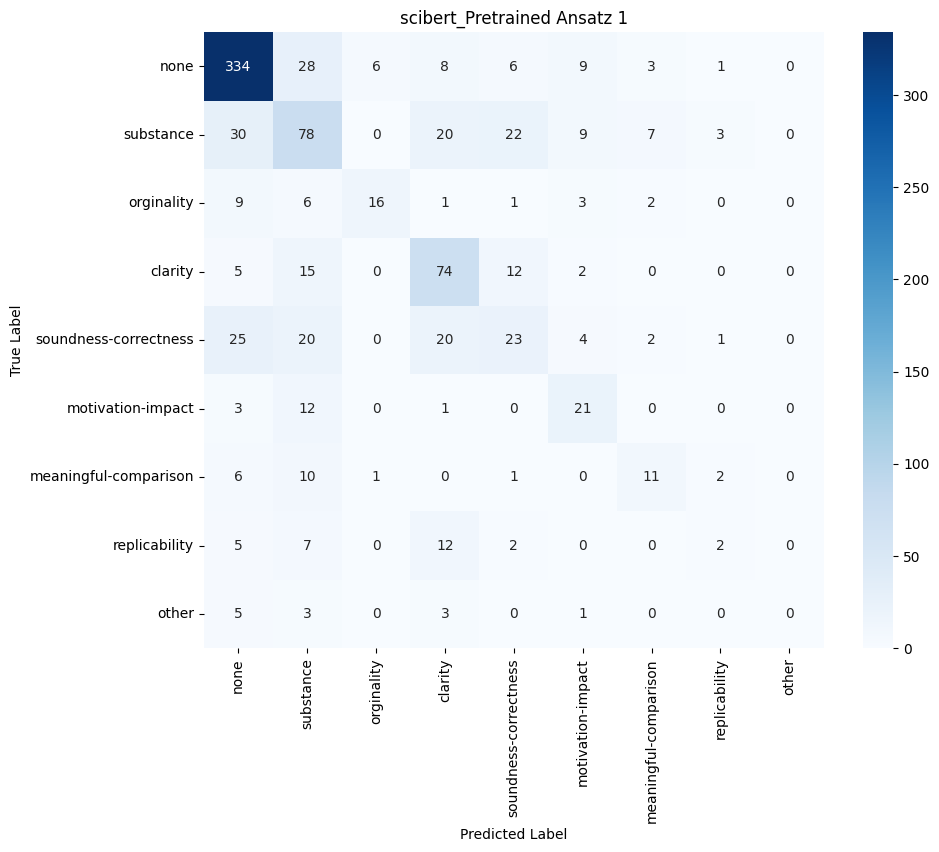

c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                 none       0.79      0.85      0.82       395
            substance       0.44      0.46      0.45       169
           orginality       0.70      0.42      0.52        38
              clarity       0.53      0.69      0.60       108
soundness-correctness       0.34      0.24      0.28        95
    motivation-impact       0.43      0.57      0.49        37
meaningful-comparison       0.44      0.35      0.39        31
        replicability       0.22      0.07      0.11        28
                other       0.00      0.00      0.00        12

             accuracy                           0.61       913
            macro avg       0.43      0.41      0.41       913
         weighted avg       0.59      0.61      0.60       913


>>> scibert_Pretrained - Ansatz (2) - VOLLES Oversampling


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\scibert_all\scibert_scivocab_uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. 

  0%|          | 0/7990 [00:00<?, ?it/s]

{'loss': 1.1381, 'grad_norm': 9.19530200958252, 'learning_rate': 4.687108886107635e-05, 'epoch': 0.63}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.2277532815933228, 'eval_accuracy': 0.608433734939759, 'eval_runtime': 430.6628, 'eval_samples_per_second': 4.24, 'eval_steps_per_second': 0.067, 'epoch': 1.0}
{'loss': 0.6626, 'grad_norm': 5.948514938354492, 'learning_rate': 4.374217772215269e-05, 'epoch': 1.25}
{'loss': 0.4036, 'grad_norm': 13.723193168640137, 'learning_rate': 4.0613266583229035e-05, 'epoch': 1.88}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.5266444683074951, 'eval_accuracy': 0.6078860898138007, 'eval_runtime': 433.4145, 'eval_samples_per_second': 4.213, 'eval_steps_per_second': 0.067, 'epoch': 2.0}
{'loss': 0.212, 'grad_norm': 19.51515007019043, 'learning_rate': 3.7484355444305386e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.1638410091400146, 'eval_accuracy': 0.6078860898138007, 'eval_runtime': 433.628, 'eval_samples_per_second': 4.211, 'eval_steps_per_second': 0.067, 'epoch': 3.0}
{'loss': 0.1492, 'grad_norm': 0.9144070148468018, 'learning_rate': 3.435544430538173e-05, 'epoch': 3.13}
{'loss': 0.0814, 'grad_norm': 0.09334000945091248, 'learning_rate': 3.1226533166458075e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.673246145248413, 'eval_accuracy': 0.5947426067907996, 'eval_runtime': 434.9085, 'eval_samples_per_second': 4.199, 'eval_steps_per_second': 0.067, 'epoch': 4.0}
{'train_runtime': 47973.1303, 'train_samples_per_second': 2.664, 'train_steps_per_second': 0.167, 'train_loss': 0.42115181706873733, 'epoch': 4.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (2) - Final Test Results: {'eval_loss': 1.2740145921707153, 'eval_accuracy': 0.5903614457831325, 'eval_runtime': 341.9838, 'eval_samples_per_second': 2.67, 'eval_steps_per_second': 0.044, 'epoch': 4.0}


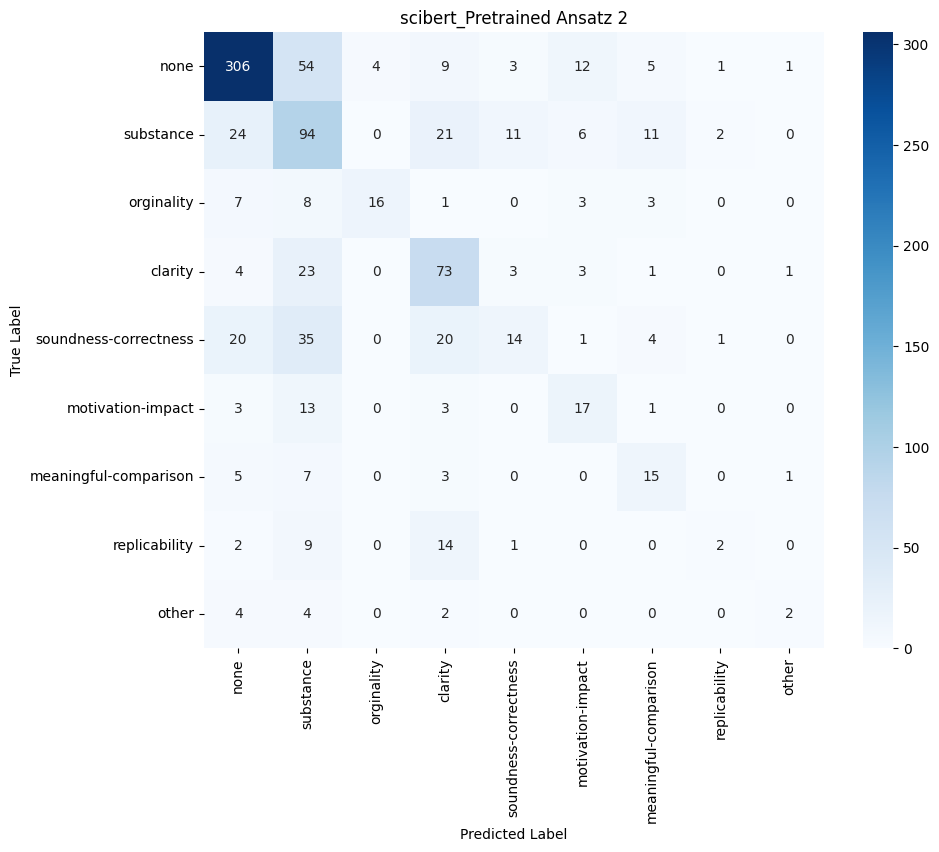

                       precision    recall  f1-score   support

                 none       0.82      0.77      0.79       395
            substance       0.38      0.56      0.45       169
           orginality       0.80      0.42      0.55        38
              clarity       0.50      0.68      0.57       108
soundness-correctness       0.44      0.15      0.22        95
    motivation-impact       0.40      0.46      0.43        37
meaningful-comparison       0.38      0.48      0.42        31
        replicability       0.33      0.07      0.12        28
                other       0.40      0.17      0.24        12

             accuracy                           0.59       913
            macro avg       0.49      0.42      0.42       913
         weighted avg       0.61      0.59      0.58       913


>>> scibert_Pretrained - Ansatz (3) - 1 Epoche Oversampling + 1 Epoche kein Oversampling


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at C:\Users\carme\OneDrive - Appelt Steuerberatung\Carmen Appelt\Master\Semester 3\DASP\models\scibert_all\scibert_scivocab_uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. 

  0%|          | 0/7990 [00:00<?, ?it/s]

{'loss': 1.1486, 'grad_norm': 9.17329216003418, 'learning_rate': 4.687108886107635e-05, 'epoch': 0.63}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.2426731586456299, 'eval_accuracy': 0.5996714129244249, 'eval_runtime': 636.6396, 'eval_samples_per_second': 2.868, 'eval_steps_per_second': 0.046, 'epoch': 1.0}
{'loss': 0.6819, 'grad_norm': 7.978579521179199, 'learning_rate': 4.374217772215269e-05, 'epoch': 1.25}
{'loss': 0.4205, 'grad_norm': 9.251935005187988, 'learning_rate': 4.0613266583229035e-05, 'epoch': 1.88}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.5577634572982788, 'eval_accuracy': 0.617196056955093, 'eval_runtime': 438.7892, 'eval_samples_per_second': 4.161, 'eval_steps_per_second': 0.066, 'epoch': 2.0}
{'loss': 0.2152, 'grad_norm': 21.40260124206543, 'learning_rate': 3.7484355444305386e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.1815218925476074, 'eval_accuracy': 0.6100766703176341, 'eval_runtime': 411.3517, 'eval_samples_per_second': 4.439, 'eval_steps_per_second': 0.07, 'epoch': 3.0}
{'loss': 0.1525, 'grad_norm': 6.210367202758789, 'learning_rate': 3.435544430538173e-05, 'epoch': 3.13}
{'loss': 0.0912, 'grad_norm': 0.03192702308297157, 'learning_rate': 3.1226533166458075e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.650151014328003, 'eval_accuracy': 0.608433734939759, 'eval_runtime': 410.6233, 'eval_samples_per_second': 4.447, 'eval_steps_per_second': 0.071, 'epoch': 4.0}
{'loss': 0.0615, 'grad_norm': 0.00591172045096755, 'learning_rate': 2.809762202753442e-05, 'epoch': 4.38}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.0791068077087402, 'eval_accuracy': 0.5947426067907996, 'eval_runtime': 292.4108, 'eval_samples_per_second': 6.245, 'eval_steps_per_second': 0.099, 'epoch': 5.0}
{'train_runtime': 56768.0791, 'train_samples_per_second': 2.251, 'train_steps_per_second': 0.141, 'train_loss': 0.3519328889620021, 'epoch': 5.0}


c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.7721670866012573, 'eval_accuracy': 0.6133625410733844, 'eval_runtime': 296.6255, 'eval_samples_per_second': 6.156, 'eval_steps_per_second': 0.098, 'epoch': 1.0}
{'loss': 0.2878, 'grad_norm': 22.473371505737305, 'learning_rate': 4.375e-05, 'epoch': 1.25}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.247973680496216, 'eval_accuracy': 0.608433734939759, 'eval_runtime': 297.2958, 'eval_samples_per_second': 6.142, 'eval_steps_per_second': 0.098, 'epoch': 2.0}
{'loss': 0.1419, 'grad_norm': 0.4452354609966278, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.6730055809020996, 'eval_accuracy': 0.6056955093099672, 'eval_runtime': 296.4807, 'eval_samples_per_second': 6.159, 'eval_steps_per_second': 0.098, 'epoch': 3.0}
{'loss': 0.0881, 'grad_norm': 0.9812440872192383, 'learning_rate': 3.125e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.0750911235809326, 'eval_accuracy': 0.5711938663745892, 'eval_runtime': 291.6583, 'eval_samples_per_second': 6.261, 'eval_steps_per_second': 0.099, 'epoch': 4.0}
{'train_runtime': 17048.1692, 'train_samples_per_second': 3.748, 'train_steps_per_second': 0.235, 'train_loss': 0.16473788291215896, 'epoch': 4.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (3) - Final Test Results: {'eval_loss': 1.7262176275253296, 'eval_accuracy': 0.6078860898138007, 'eval_runtime': 224.2919, 'eval_samples_per_second': 4.071, 'eval_steps_per_second': 0.067, 'epoch': 4.0}


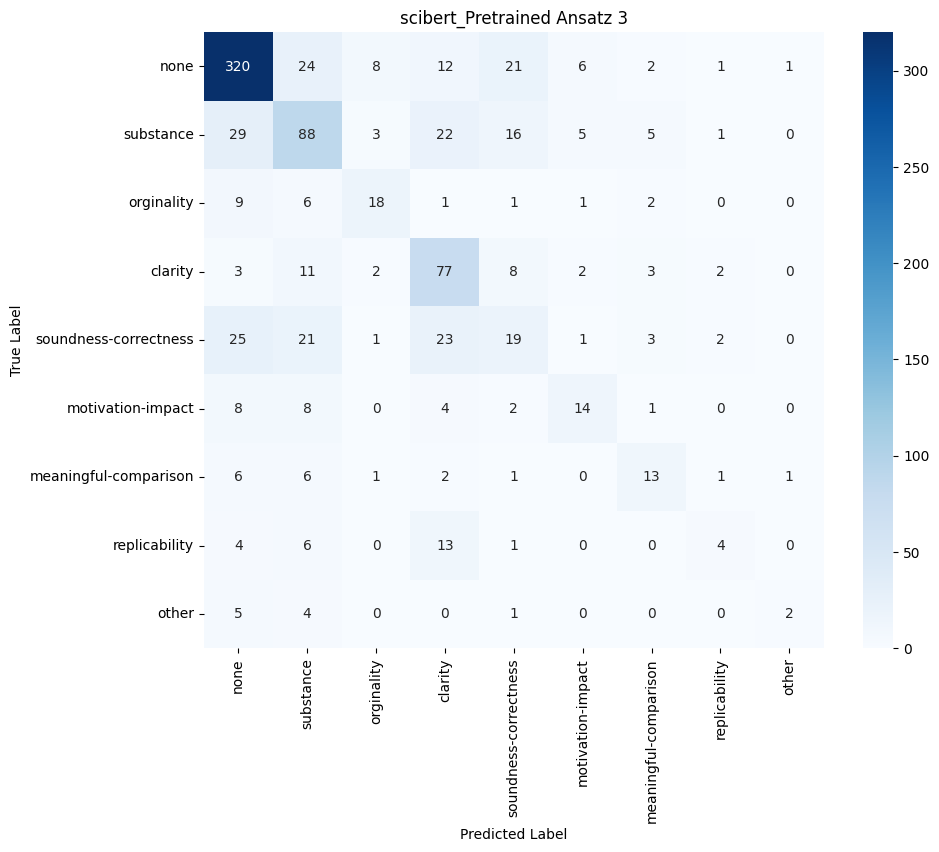

                       precision    recall  f1-score   support

                 none       0.78      0.81      0.80       395
            substance       0.51      0.52      0.51       169
           orginality       0.55      0.47      0.51        38
              clarity       0.50      0.71      0.59       108
soundness-correctness       0.27      0.20      0.23        95
    motivation-impact       0.48      0.38      0.42        37
meaningful-comparison       0.45      0.42      0.43        31
        replicability       0.36      0.14      0.21        28
                other       0.50      0.17      0.25        12

             accuracy                           0.61       913
            macro avg       0.49      0.42      0.44       913
         weighted avg       0.59      0.61      0.60       913

Starte Trainingsrunden für Modell: scibert_Original

>>> scibert_Original - Ansatz (1) - KEIN Oversampling


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

c:\Users\carme\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\carme\.cache\huggingface\hub\models--allenai--scibert_scivocab_uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4000 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.1786948442459106, 'eval_accuracy': 0.6024096385542169, 'eval_runtime': 300.7073, 'eval_samples_per_second': 6.072, 'eval_steps_per_second': 0.096, 'epoch': 1.0}
{'loss': 1.235, 'grad_norm': 9.206815719604492, 'learning_rate': 4.375e-05, 'epoch': 1.25}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.1728767156600952, 'eval_accuracy': 0.624315443592552, 'eval_runtime': 293.1024, 'eval_samples_per_second': 6.23, 'eval_steps_per_second': 0.099, 'epoch': 2.0}
{'loss': 0.8056, 'grad_norm': 12.810481071472168, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.2764575481414795, 'eval_accuracy': 0.6177437020810514, 'eval_runtime': 305.2765, 'eval_samples_per_second': 5.981, 'eval_steps_per_second': 0.095, 'epoch': 3.0}
{'loss': 0.4446, 'grad_norm': 24.483083724975586, 'learning_rate': 3.125e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.625402808189392, 'eval_accuracy': 0.6062431544359255, 'eval_runtime': 334.8469, 'eval_samples_per_second': 5.453, 'eval_steps_per_second': 0.087, 'epoch': 4.0}
{'loss': 0.1894, 'grad_norm': 13.563538551330566, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.056135416030884, 'eval_accuracy': 0.5930996714129244, 'eval_runtime': 438.3713, 'eval_samples_per_second': 4.165, 'eval_steps_per_second': 0.066, 'epoch': 5.0}
{'train_runtime': 22036.9474, 'train_samples_per_second': 2.9, 'train_steps_per_second': 0.182, 'train_loss': 0.6686273536682129, 'epoch': 5.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (1) - Final Test Results: {'eval_loss': 1.1786024570465088, 'eval_accuracy': 0.619934282584885, 'eval_runtime': 344.5984, 'eval_samples_per_second': 2.649, 'eval_steps_per_second': 0.044, 'epoch': 5.0}


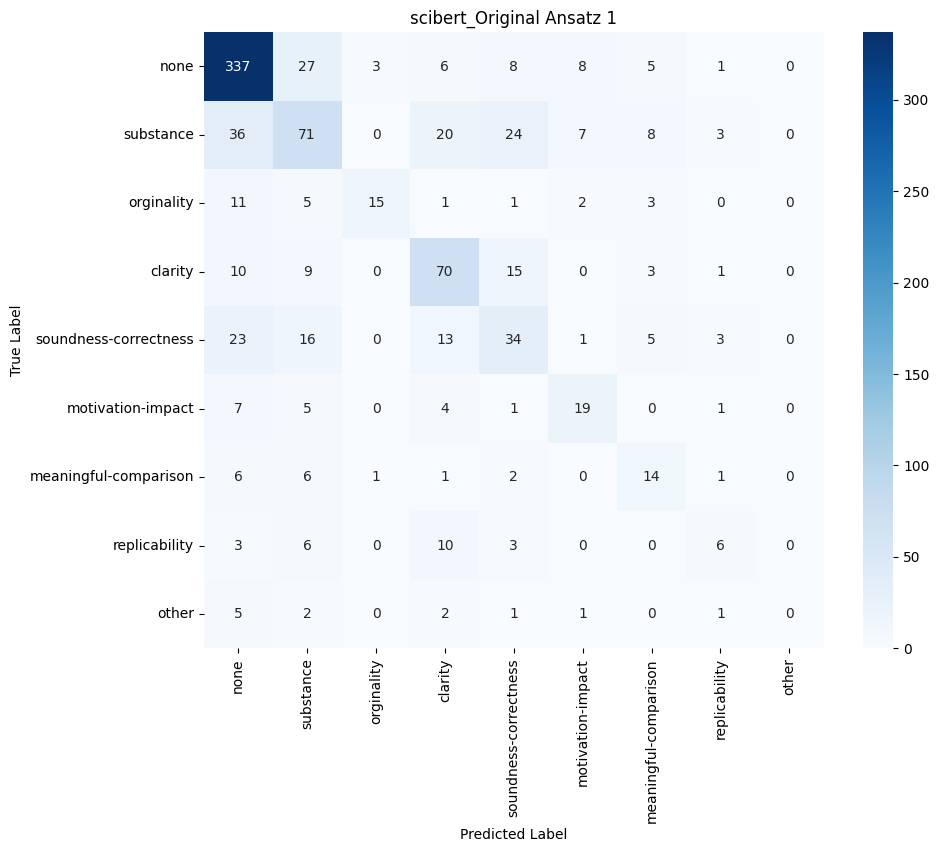

c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\carme\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                 none       0.77      0.85      0.81       395
            substance       0.48      0.42      0.45       169
           orginality       0.79      0.39      0.53        38
              clarity       0.55      0.65      0.60       108
soundness-correctness       0.38      0.36      0.37        95
    motivation-impact       0.50      0.51      0.51        37
meaningful-comparison       0.37      0.45      0.41        31
        replicability       0.35      0.21      0.27        28
                other       0.00      0.00      0.00        12

             accuracy                           0.62       913
            macro avg       0.47      0.43      0.44       913
         weighted avg       0.60      0.62      0.61       913


>>> scibert_Original - Ansatz (2) - VOLLES Oversampling


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/7990 [00:00<?, ?it/s]

{'loss': 1.2187, 'grad_norm': 9.900580406188965, 'learning_rate': 4.687108886107635e-05, 'epoch': 0.63}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.2104685306549072, 'eval_accuracy': 0.6089813800657174, 'eval_runtime': 286.6792, 'eval_samples_per_second': 6.369, 'eval_steps_per_second': 0.101, 'epoch': 1.0}
{'loss': 0.7413, 'grad_norm': 8.383334159851074, 'learning_rate': 4.374217772215269e-05, 'epoch': 1.25}
{'loss': 0.4761, 'grad_norm': 14.750472068786621, 'learning_rate': 4.0613266583229035e-05, 'epoch': 1.88}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.5033928155899048, 'eval_accuracy': 0.6046002190580504, 'eval_runtime': 300.7607, 'eval_samples_per_second': 6.071, 'eval_steps_per_second': 0.096, 'epoch': 2.0}
{'loss': 0.2477, 'grad_norm': 29.219030380249023, 'learning_rate': 3.7484355444305386e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.0087106227874756, 'eval_accuracy': 0.6204819277108434, 'eval_runtime': 302.789, 'eval_samples_per_second': 6.031, 'eval_steps_per_second': 0.096, 'epoch': 3.0}
{'loss': 0.1937, 'grad_norm': 33.05996322631836, 'learning_rate': 3.435544430538173e-05, 'epoch': 3.13}
{'loss': 0.116, 'grad_norm': 0.14441636204719543, 'learning_rate': 3.1226533166458075e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.368216037750244, 'eval_accuracy': 0.6144578313253012, 'eval_runtime': 295.969, 'eval_samples_per_second': 6.17, 'eval_steps_per_second': 0.098, 'epoch': 4.0}
{'loss': 0.0906, 'grad_norm': 6.17035436630249, 'learning_rate': 2.809762202753442e-05, 'epoch': 4.38}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.9040334224700928, 'eval_accuracy': 0.6046002190580504, 'eval_runtime': 324.3797, 'eval_samples_per_second': 5.629, 'eval_steps_per_second': 0.089, 'epoch': 5.0}
{'loss': 0.0676, 'grad_norm': 0.006018774583935738, 'learning_rate': 2.4968710888610763e-05, 'epoch': 5.01}
{'loss': 0.0317, 'grad_norm': 0.029698967933654785, 'learning_rate': 2.183979974968711e-05, 'epoch': 5.63}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.0553276538848877, 'eval_accuracy': 0.6128148959474261, 'eval_runtime': 332.8268, 'eval_samples_per_second': 5.486, 'eval_steps_per_second': 0.087, 'epoch': 6.0}
{'train_runtime': 51072.6534, 'train_samples_per_second': 2.502, 'train_steps_per_second': 0.156, 'train_loss': 0.333441645988684, 'epoch': 6.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (2) - Final Test Results: {'eval_loss': 2.0999679565429688, 'eval_accuracy': 0.6111719605695509, 'eval_runtime': 253.4058, 'eval_samples_per_second': 3.603, 'eval_steps_per_second': 0.059, 'epoch': 6.0}


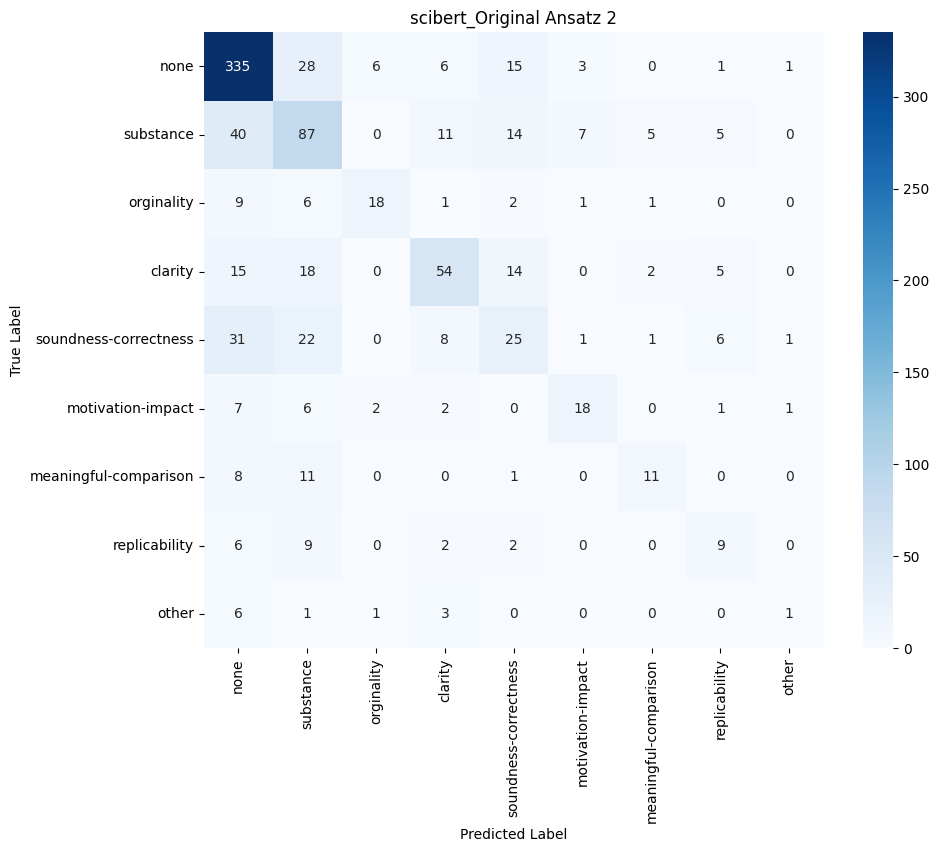

                       precision    recall  f1-score   support

                 none       0.73      0.85      0.79       395
            substance       0.46      0.51      0.49       169
           orginality       0.67      0.47      0.55        38
              clarity       0.62      0.50      0.55       108
soundness-correctness       0.34      0.26      0.30        95
    motivation-impact       0.60      0.49      0.54        37
meaningful-comparison       0.55      0.35      0.43        31
        replicability       0.33      0.32      0.33        28
                other       0.25      0.08      0.12        12

             accuracy                           0.61       913
            macro avg       0.51      0.43      0.46       913
         weighted avg       0.60      0.61      0.60       913


>>> scibert_Original - Ansatz (3) - 1 Epoche Oversampling + 1 Epoche kein Oversampling


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/7990 [00:00<?, ?it/s]

{'loss': 1.2003, 'grad_norm': 8.413241386413574, 'learning_rate': 4.687108886107635e-05, 'epoch': 0.63}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.2506446838378906, 'eval_accuracy': 0.5991237677984665, 'eval_runtime': 332.376, 'eval_samples_per_second': 5.494, 'eval_steps_per_second': 0.087, 'epoch': 1.0}
{'loss': 0.7114, 'grad_norm': 5.115534782409668, 'learning_rate': 4.374217772215269e-05, 'epoch': 1.25}
{'loss': 0.4638, 'grad_norm': 16.271129608154297, 'learning_rate': 4.0613266583229035e-05, 'epoch': 1.88}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.6129916906356812, 'eval_accuracy': 0.6056955093099672, 'eval_runtime': 329.8476, 'eval_samples_per_second': 5.536, 'eval_steps_per_second': 0.088, 'epoch': 2.0}
{'loss': 0.2495, 'grad_norm': 10.94987964630127, 'learning_rate': 3.7484355444305386e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.1113693714141846, 'eval_accuracy': 0.6024096385542169, 'eval_runtime': 298.9815, 'eval_samples_per_second': 6.107, 'eval_steps_per_second': 0.097, 'epoch': 3.0}
{'loss': 0.1809, 'grad_norm': 4.23591423034668, 'learning_rate': 3.435544430538173e-05, 'epoch': 3.13}
{'loss': 0.1069, 'grad_norm': 2.2243783473968506, 'learning_rate': 3.1226533166458075e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.6759555339813232, 'eval_accuracy': 0.6056955093099672, 'eval_runtime': 305.741, 'eval_samples_per_second': 5.972, 'eval_steps_per_second': 0.095, 'epoch': 4.0}
{'loss': 0.084, 'grad_norm': 1.976039171218872, 'learning_rate': 2.809762202753442e-05, 'epoch': 4.38}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.6603338718414307, 'eval_accuracy': 0.6046002190580504, 'eval_runtime': 423.7492, 'eval_samples_per_second': 4.309, 'eval_steps_per_second': 0.068, 'epoch': 5.0}
{'train_runtime': 47078.8677, 'train_samples_per_second': 2.715, 'train_steps_per_second': 0.17, 'train_loss': 0.3825465162943242, 'epoch': 5.0}


c:\Users\carme\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\carme\AppData\Local\Temp\ipykernel_20608\3865514688.py:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 1.6904816627502441, 'eval_accuracy': 0.5903614457831325, 'eval_runtime': 293.9698, 'eval_samples_per_second': 6.212, 'eval_steps_per_second': 0.099, 'epoch': 1.0}
{'loss': 0.3106, 'grad_norm': 3.5390052795410156, 'learning_rate': 4.375e-05, 'epoch': 1.25}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.2962965965270996, 'eval_accuracy': 0.5870755750273823, 'eval_runtime': 297.4926, 'eval_samples_per_second': 6.138, 'eval_steps_per_second': 0.097, 'epoch': 2.0}
{'loss': 0.1673, 'grad_norm': 9.158904075622559, 'learning_rate': 3.7500000000000003e-05, 'epoch': 2.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.603793144226074, 'eval_accuracy': 0.5920043811610076, 'eval_runtime': 295.6043, 'eval_samples_per_second': 6.177, 'eval_steps_per_second': 0.098, 'epoch': 3.0}
{'loss': 0.1003, 'grad_norm': 76.7171630859375, 'learning_rate': 3.125e-05, 'epoch': 3.75}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 2.861910581588745, 'eval_accuracy': 0.6029572836801752, 'eval_runtime': 285.0112, 'eval_samples_per_second': 6.407, 'eval_steps_per_second': 0.102, 'epoch': 4.0}
{'loss': 0.0506, 'grad_norm': 0.030557356774806976, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.000389575958252, 'eval_accuracy': 0.6073384446878423, 'eval_runtime': 298.7713, 'eval_samples_per_second': 6.112, 'eval_steps_per_second': 0.097, 'epoch': 5.0}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.3167970180511475, 'eval_accuracy': 0.6018619934282585, 'eval_runtime': 295.3578, 'eval_samples_per_second': 6.182, 'eval_steps_per_second': 0.098, 'epoch': 6.0}
{'loss': 0.0116, 'grad_norm': 0.4556983411312103, 'learning_rate': 1.8750000000000002e-05, 'epoch': 6.25}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.4349493980407715, 'eval_accuracy': 0.5947426067907996, 'eval_runtime': 287.4801, 'eval_samples_per_second': 6.352, 'eval_steps_per_second': 0.101, 'epoch': 7.0}
{'loss': 0.0076, 'grad_norm': 0.0027592298574745655, 'learning_rate': 1.25e-05, 'epoch': 7.5}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.487692356109619, 'eval_accuracy': 0.604052573932092, 'eval_runtime': 285.877, 'eval_samples_per_second': 6.387, 'eval_steps_per_second': 0.101, 'epoch': 8.0}
{'train_runtime': 33987.7613, 'train_samples_per_second': 1.88, 'train_steps_per_second': 0.118, 'train_loss': 0.10160403225570917, 'epoch': 8.0}


  0%|          | 0/15 [00:00<?, ?it/s]

Ansatz (3) - Final Test Results: {'eval_loss': 3.0014798641204834, 'eval_accuracy': 0.6067907995618839, 'eval_runtime': 222.7801, 'eval_samples_per_second': 4.098, 'eval_steps_per_second': 0.067, 'epoch': 8.0}


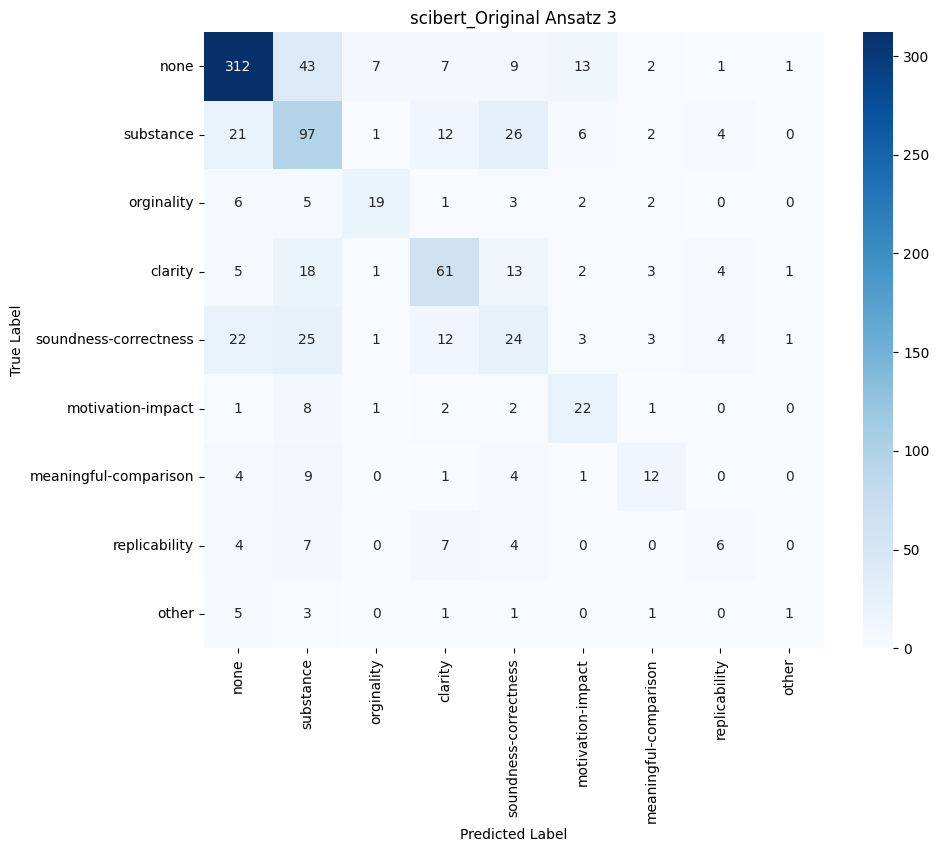

                       precision    recall  f1-score   support

                 none       0.82      0.79      0.81       395
            substance       0.45      0.57      0.51       169
           orginality       0.63      0.50      0.56        38
              clarity       0.59      0.56      0.58       108
soundness-correctness       0.28      0.25      0.27        95
    motivation-impact       0.45      0.59      0.51        37
meaningful-comparison       0.46      0.39      0.42        31
        replicability       0.32      0.21      0.26        28
                other       0.25      0.08      0.12        12

             accuracy                           0.61       913
            macro avg       0.47      0.44      0.45       913
         weighted avg       0.61      0.61      0.61       913

Fertig!


In [8]:

# Example imports (adjust or replace as needed):
# Ensure you have imported the necessary libraries and modules like:
# - `train_approach_1`, `train_approach_2`, `train_approach_3`
# - `plot_confusion_matrix`
# - Hugging Face model/tokenizer classes like BertForSequenceClassification, etc.

for model_name, path in model_paths.items():  # Iterate over all model paths
    print("="*60)
    print(f"Starte Trainingsrunden für Modell: {model_name}")
    print("="*60)

    # Dynamically select the appropriate model and tokenizer class
    # Example: Use different classes for BERT, RoBERTa, or default to Auto classes
    if model_name == "BERT":
        model_class = BertForSequenceClassification
        tokenizer_class = BertTokenizer
    elif model_name == "RoBERTa":
        model_class = RobertaForSequenceClassification
        tokenizer_class = RobertaTokenizer
    else:
        # For other models like SciBERT, use the Auto classes
        model_class = AutoModelForSequenceClassification
        tokenizer_class = AutoTokenizer

    # Approach 1: Training without oversampling
    print(f"\n>>> {model_name} - Ansatz (1) - KEIN Oversampling")
    model1, tokenizer1, trainer1 = train_approach_1(model_class, tokenizer_class, path, model_name)
    # Plot confusion matrix for Approach 1
    plot_confusion_matrix(model1, tokenizer1, test_df, title=f"{model_name} Ansatz 1")

    # Approach 2: Training with full oversampling
    print(f"\n>>> {model_name} - Ansatz (2) - VOLLES Oversampling")
    model2, tokenizer2, trainer2 = train_approach_2(model_class, tokenizer_class, path, model_name)
    # Plot confusion matrix for Approach 2
    plot_confusion_matrix(model2, tokenizer2, test_df, title=f"{model_name} Ansatz 2")

    # Approach 3: Training with 1 epoch oversampling + 1 epoch without oversampling
    print(f"\n>>> {model_name} - Ansatz (3) - 1 Epoche Oversampling + 1 Epoche kein Oversampling")
    model3, tokenizer3, trainer3 = train_approach_3(model_class, tokenizer_class, path, model_name)
    # Plot confusion matrix for Approach 3
    plot_confusion_matrix(model3, tokenizer3, test_df, title=f"{model_name} Ansatz 3")

print("Fertig!")
